# Extracting data from listings of properties for sale

## 1. Importing packages

In [129]:
#Importing the packages that will be used
#BeautifulSoup to make the parse from the html and collect the data from the website html
from bs4 import BeautifulSoup

#requests to make the requests to the website and get the html from the page
import requests

#In this case we will use pandas only to save the data and help save the data in a CSV file
import pandas as pd

#To create delays between requests to the website
import time

#To create random values for the delays between requests
import random

#to get the information about date and time to follow the progress of the data extraction, because we will get too many data
#and will do too many requests that will take about 6 to 7 hours to collect the data
from datetime import datetime

## 2. Web Scrappig the Data from OLX

https://olx.com.br/

OLX is a website for the user list what they want to sell and other users can search for things to buy, it is really famous in Brazil \
The image below shows how the page listing the sales looks like:


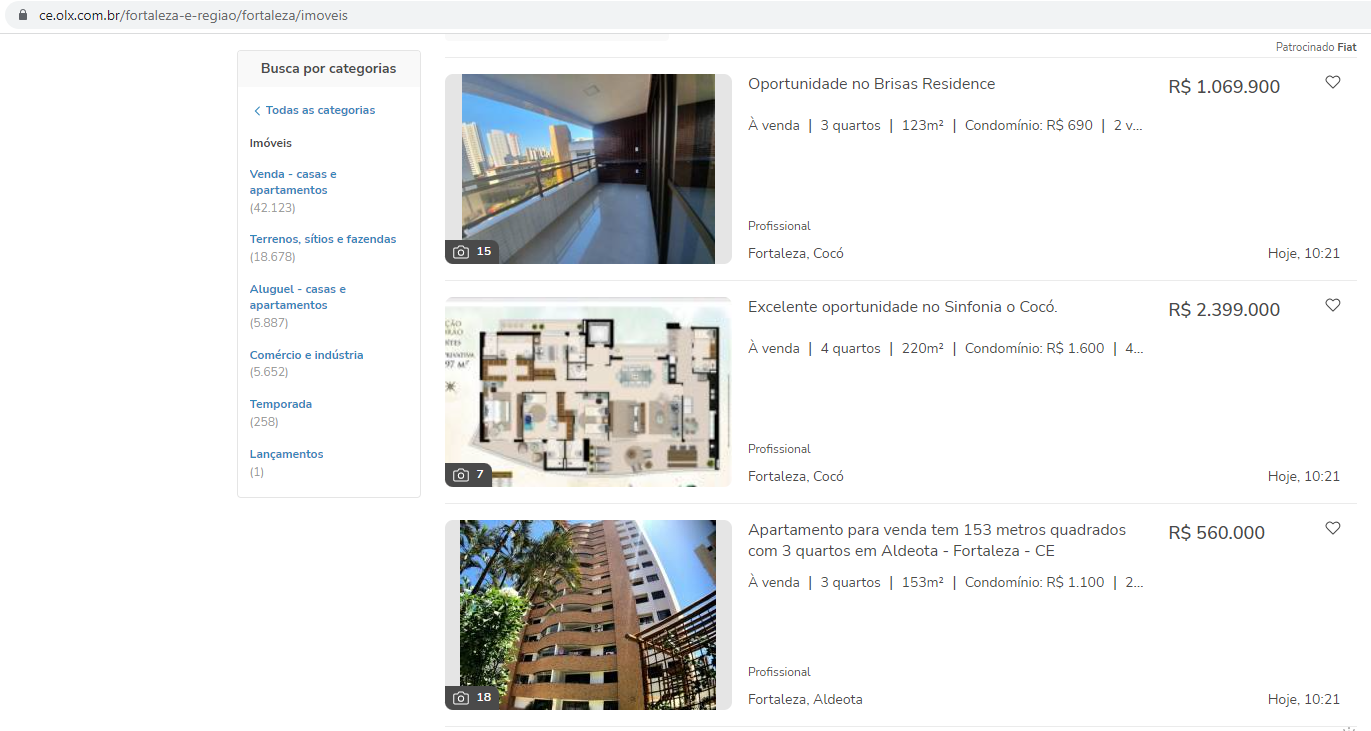

The image below shows how the page of a property looks like:

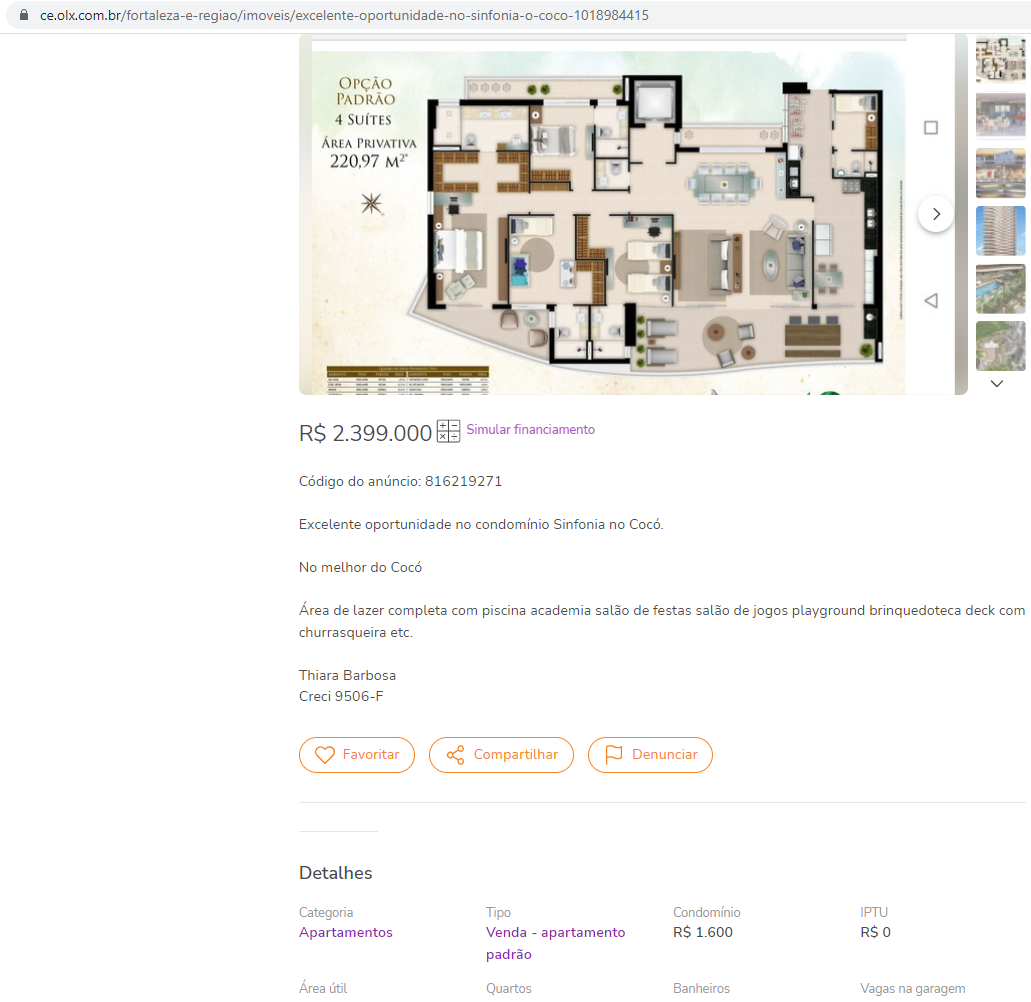

### 2.1. Defining the parameters to be used

In [66]:
#Headers to be used to fake you are accessing by browser, some websites do not accept requests directly
headers = {
    'authority': 'ce.olx.com.br',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'accept-language': 'en-US,en;q=0.9',
    'referer': 'https://ce.olx.com.br/fortaleza-e-regiao/imoveis?o=2',
    'sec-ch-ua': '"Chromium";v="104", " Not A;Brand";v="99", "Google Chrome";v="104"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    #user-agent is the most important to be used, the others can be used or not
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36',
}
#parameter to navigate in the pages from our search
params = {
    'o': '2',
}

### 2.2. Collecting the houses urls 

In [67]:
def get_urls(page):
    """Function to collect the houses URLs from the page's html"""
    soup = BeautifulSoup(page.text, 'html.parser')
    #To define where to get the information I used Google Chrome Inspection function and search where the URLs was located
    properties = soup.find('div',{"id":'column-main-content'}).find_all("a", {"data-lurker-detail":"list_id"})
    link_list = []
    for item in properties:
        link_list.append(item['href'])
    return link_list

In [68]:
#First running for the great Fortaleza area without the properties of Fortaleza city
url = 'https://ce.olx.com.br/fortaleza-e-regiao/grande-fortaleza/imoveis/venda'
page = requests.get(url, headers=headers)
properties_urls = get_urls(page)
for i in range(2,105):
    #Using the Google Chrome Inspection function and evaluating the requests in the network area
    #I saw the parameter used to select the pages of the results was the parameter 'o' with the value of the page number
    params['o'] = str(i)
    page = requests.get(url,params=params, headers=headers)
    if page.status_code == 200:
        properties_urls = properties_urls + get_urls(page)
    #Delay of 5 seconds between requests, so we avoid be blocked by websites with too many requests in short time
    #the website can think it is an attack if we send too many requests consecutively
    time.sleep(5)
    #Print the quantity of URLs collected to check the progress
    print(len(properties_urls))

100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200


In [69]:
#Removing duplicates if exist
set_URLs = set(properties_urls)
print("Total with duplicates: "+str(len(properties_urls)))
print("Total without duplicates: "+str(len(set_URLs)))

Total with duplicates: 5200
Total without duplicates: 5000


In [70]:
#saving the information to a CSV file, just for the case we get some problem we do not need collect the information again
df_URLs = pd.DataFrame(set_URLs)
df_URLs.to_csv('./Resources/properties_URLs_Great_Fortaleza.csv', index=False, header=False)
df_URLs.head()

,0
0,https://ce.olx.com.br/fortaleza-e-regiao/imove...
1,https://ce.olx.com.br/fortaleza-e-regiao/imove...
2,https://ce.olx.com.br/fortaleza-e-regiao/imove...
3,https://ce.olx.com.br/fortaleza-e-regiao/imove...
4,https://ce.olx.com.br/fortaleza-e-regiao/imove...


### 2.2. Access each URL and get the houses information

In [71]:
#Define functions to be used in the parse from the HTML of OLX
def get_Text_if_notNone(data):
    """If not None returns the text attribute else returns None"""
    if data is not None:
        return data.text
    else:
        return None

def get_Next_Element_Text_if_notNone(data):
    """If not None returns the text attribute of the next element else returns None"""
    if data is not None:
        return data.next_element.next_element.text
    else:
        return None

def ScrapData_to_DataFrameOLX(page, dfData):
    """Makes the parse of the HTML data to a dataframe format"""
    
    soup = BeautifulSoup(page.text, 'html.parser')
    Price = soup.find('div',{'data-testid':'ad-price-wrapper'})
    if Price is not None:
        Price = get_Text_if_notNone(Price.find('h2',class_='sc-1wimjbb-1 bQzdqU sc-ifAKCX cmFKIN'))
        if Price is None:
            return dfData
        elif Price == 'R$ 0':
            return dfData
    else:
        return dfData
    
    Description = get_Text_if_notNone(soup
                                      .find('div',class_='sc-1sj3nln-0 eSLnCp').
                                      find('span',class_='sc-1sj3nln-1 eOSweo sc-ifAKCX cmFKIN'))
    
    div_properties = soup.find_all('div',{'data-testid':'ad-properties'})
    
    Category = get_Next_Element_Text_if_notNone(div_properties[0]
                                                .find('dt',string='Categoria'))
    Type = get_Next_Element_Text_if_notNone(div_properties[0]
                                            .find('dt',string='Tipo'))
    Cond_Price = get_Next_Element_Text_if_notNone(div_properties[0]
                                                  .find('dt',string='Condomínio')) 
    IPTU_Price = get_Next_Element_Text_if_notNone(div_properties[0]
                                                  .find('dt',string='IPTU')) 
    Area = get_Next_Element_Text_if_notNone(div_properties[0]
                                            .find('dt',string='Área útil')) 
    if Area is None:
        Area = get_Next_Element_Text_if_notNone(div_properties[0]
                                            .find('dt',string='Área construída'))
    Bedrooms = get_Next_Element_Text_if_notNone(div_properties[0]
                                                .find('dt',string='Quartos')) 
    Bathrooms = get_Next_Element_Text_if_notNone(div_properties[0]
                                                 .find('dt',string='Banheiros'))
    Garage = get_Next_Element_Text_if_notNone(div_properties[0]
                                              .find('dt',string='Vagas na garagem')) 
    Property_Detail = get_Next_Element_Text_if_notNone(div_properties[0]
                                                       .find('dt',string='Detalhes do imóvel')) 
    Cond_Detail = get_Next_Element_Text_if_notNone(div_properties[0]
                                                   .find('dt',string='Detalhes do condominio'))   
    Zipcode = get_Next_Element_Text_if_notNone(div_properties[1]
                                               .find('dt',string='CEP'))    
    City = get_Next_Element_Text_if_notNone(div_properties[1]
                                            .find('dt',string='Município'))    
    Neighboor = get_Next_Element_Text_if_notNone(div_properties[1]
                                                 .find('dt',string='Bairro'))    
    Address = get_Next_Element_Text_if_notNone(div_properties[1]
                                               .find('dt',string='Logradouro'))    
    new_row = {'Category':Category,
               'Type':Type,
               'Cond_Price':Cond_Price,
               'IPTU_Price':IPTU_Price,
               'Area':Area,
               'Bedrooms':Bedrooms,
               'Bathrooms':Bathrooms,
               'Garage':Garage,
               'Property_Detail':Property_Detail,
               'Cond_Detail':Cond_Detail,
               'Price':Price,
               'Zipcode':Zipcode,
               'City':City,
               'Neighboor':Neighboor,
               'Address':Address, 
               'Description':Description}
    dfData = dfData.append(new_row, ignore_index = True)
    return dfData

In [72]:
#Transforming to List, to easily slice the list, since we will do a lot of requests to the same website, 
#sometimes it can block our access per a period, so to start from where you stopped you can check how many URLs 
#you already got the information and start from the next item in the list
properties_urls = list(set_URLs)

In [ ]:
#Defining the dataframe that will be used to store the data of the Houses and starting a counter to know how many
#URLs we already got the information
df_Properties = pd.DataFrame(columns=['Category',
                                      'Type',
                                      'Cond_Price',
                                      'IPTU_Price',
                                      'Area',
                                      'Bedrooms',
                                      'Bathrooms',
                                      'Garage',
                                      'Property_Detail',
                                      'Cond_Detail',
                                      'Price',
                                      'Zipcode',
                                      'City',
                                      'Neighboor',
                                      'Address',
                                      'Description'])
count = 0

In [75]:
#Iterate over the set_URLs and access the URL and collect the data 
#and parse it to a dataframe
for item in properties_urls:
    url = item
    page = requests.get(url, headers=headers)
    if page.status_code == 200:
        df_Properties = ScrapData_to_DataFrameOLX(page, df_Properties)
    wait_time = random.randrange(2, 10, 1) 
    time.sleep(wait_time)
    count=count+1
    if count%100 == 0:
        #Print date and time and also the quantity of URLs already collected, so in this way we can follow the progress
        print(datetime.now())
        print(count)

2022-09-02 07:07:09.382370
2600
2022-09-02 07:18:05.052890
2700
2022-09-02 07:29:04.449947
2800
2022-09-02 07:39:36.286892
2900
2022-09-02 07:50:13.482597
3000
2022-09-02 08:01:49.954276
3100
2022-09-02 08:12:51.115730
3200
2022-09-02 09:05:45.353719
3300
2022-09-02 09:16:23.270385
3400
2022-09-02 09:27:41.338476
3500
2022-09-02 09:39:23.918536
3600
2022-09-02 09:51:18.144143
3700
2022-09-02 10:02:08.437350
3800
2022-09-02 10:14:10.604434
3900
2022-09-02 10:25:54.053977
4000
2022-09-02 10:37:01.844015
4100
2022-09-02 10:48:24.819468
4200
2022-09-02 10:59:19.764449
4300
2022-09-02 11:11:20.978921
4400
2022-09-02 11:22:06.081541
4500
2022-09-02 11:33:05.649793
4600
2022-09-02 11:43:17.522693
4700
2022-09-02 11:54:15.800717
4800
2022-09-02 12:05:57.779399
4900
2022-09-02 12:17:42.662457
5000


In [76]:
print(count)

5001


In [77]:
#Save the Properties data from Great Fortaleza to a CSV file
df_Properties.to_csv('./Resources/properties_Data_Great_Fortaleza.csv', index=False)

In [ ]:
#Now running for the only Fortaleza area
url = 'https://ce.olx.com.br/fortaleza-e-regiao/fortaleza/imoveis/venda'
page = requests.get(url, headers=headers)
properties_urls = get_urls(page)
for i in range(2,105):
    #Using the Google Chrome Inspection function and evaluating the requests in the network area
    #I saw the parameter used to select the pages of the results was the parameter 'o' with the value of the page number
    params['o'] = str(i)
    page = requests.get(url,params=params, headers=headers)
    if page.status_code == 200:
        properties_urls = properties_urls + get_urls(page)
    #Delay of 5 seconds between requests, so we avoid be blocked by websites with too many requests in short time
    #the website can think it is an attack if we send too many requests consecutively
    time.sleep(5)
    #Print the quantity of URLs collected to check the progress
    print(len(properties_urls))

In [ ]:
#Removing duplicates if exist
set_URLs = set(properties_urls)
print("Total with duplicates: "+str(len(properties_urls)))
print("Total without duplicates: "+str(len(set_URLs)))

In [ ]:
#saving the information to a CSV file, just for the case we get some problem we do not need collect the information again
df_URLs = pd.DataFrame(set_URLs)
df_URLs.to_csv('./Resources/properties_URLs_Fortaleza.csv', index=False, header=False)
df_URLs.head()

In [ ]:
#Transforming to List, to easily slice the list, since we will do a lot of requests to the same website, 
#sometimes it can block our access per a period, so to start from where you stopped you can check how many URLs 
#you already got the information and start from the next item in the list
properties_urls = list(set_URLs)

In [ ]:
#Defining the dataframe that will be used to store the data of the Houses and starting a counter to know how many
#URLs we already got the information
df_Properties = pd.DataFrame(columns=['Category',
                                      'Type',
                                      'Cond_Price',
                                      'IPTU_Price',
                                      'Area',
                                      'Bedrooms',
                                      'Bathrooms',
                                      'Garage',
                                      'Property_Detail',
                                      'Cond_Detail',
                                      'Price',
                                      'Zipcode',
                                      'City',
                                      'Neighboor',
                                      'Address',
                                      'Description'])
count = 0

In [ ]:
#Iterate over the set_URLs and access the URL and collect the data 
#and parse it to a dataframe
for item in properties_urls:
    url = item
    page = requests.get(url, headers=headers)
    if page.status_code == 200:
        df_Properties = ScrapData_to_DataFrameOLX(page, df_Properties)
    wait_time = random.randrange(2, 10, 1) 
    time.sleep(wait_time)
    count=count+1
    if count%100 == 0:
        #Print date and time and also the quantity of URLs already collected, so in this way we can follow the progress
        print(datetime.now())
        print(count)

In [ ]:
print(count)

In [ ]:
#Save the Properties data from Fortaleza city to a CSV file
df_Properties.to_csv('./Resources/properties_Data_Fortaleza.csv', index=False)

In [161]:
#Putting the 2 CSV files to one data frame
df_data1 = pd.read_csv('./Resources/properties_Data_Great_Fortaleza.csv')
df_data2 = pd.read_csv('./Resources/properties_Data_Fortaleza.csv')
lst_df = [df_data1,df_data2]
df_Properties = pd.concat(lst_df, ignore_index=True, sort=False)

In [162]:
#Saving the final dataset
df_Properties.to_csv('./Resources/olx_Great_Fortaleza_220830.csv', index=False)

In [163]:
#Checking the information about the tables
df_Properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9977 entries, 0 to 9976
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         9977 non-null   object
 1   Type             9977 non-null   object
 2   Cond_Price       9558 non-null   object
 3   IPTU_Price       9303 non-null   object
 4   Area             9800 non-null   object
 5   Bedrooms         9977 non-null   object
 6   Bathrooms        9954 non-null   object
 7   Garage           9591 non-null   object
 8   Property_Detail  7231 non-null   object
 9   Cond_Detail      6877 non-null   object
 10  Price            9947 non-null   object
 11  Zipcode          9977 non-null   int64 
 12  City             9977 non-null   object
 13  Neighboor        6525 non-null   object
 14  Address          6401 non-null   object
 15  Description      9977 non-null   object
dtypes: int64(1), object(15)
memory usage: 1.2+ MB


In [164]:
#Checking how our dataset looks like
df_Properties.head()

,Category,Type,Cond_Price,IPTU_Price,Area,Bedrooms,Bathrooms,Garage,Property_Detail,Cond_Detail,Price,Zipcode,City,Neighboor,Address,Description
0,Casas,Venda - casa em condominio fechado,R$ 0,R$ 0,150m²,4,4,2,"Churrasqueira, Piscina, Área de serviço, Ar co...","Piscina, Condomínio fechado",R$ 569.000,61760000,Eusébio,NaN,NaN,Código do anúncio: CA0565\n\nRef.:5435 - Um lu...
1,Casas,Venda - casa em condominio fechado,R$ 449,NaN,230m²,4,5 ou mais,4,"Área de serviço, Varanda, Churrasqueira","Condomínio fechado, Segurança 24h, Área murada...",R$ 1.350.000,61760000,Eusébio,NaN,NaN,UMA CIDADE PENSADA PARA VOCÊ\n\nOcupando mais ...
2,Casas,Venda - casa em condominio fechado,R$ 850,R$ 0,210m²,4,4,3,"Porteiro 24h, Varanda, Ar condicionado","Permitido animais, Portão eletrônico",R$ 995.000,61760000,Eusébio,NaN,NaN,Código do anúncio: EUSEBIO1\n\nA casa de condo...
3,Casas,Venda - casa em condominio fechado,R$ 1.150,R$ 0,335m²,4,4,4,"Piscina, Área de serviço",Piscina,R$ 4.000.000,61760000,Eusébio,NaN,NaN,Código do anúncio: 85\n\nALPHAVILLE - FORTALEZ...
4,Apartamentos,Venda - apartamento padrão,R$ 0,R$ 0,50m²,2,1,1,NaN,NaN,R$ 35.000,61650290,Caucaia,Parque Guadalajara (Jurema),Rua Poebla,Código do anúncio: 1M0JU63\n\nRepasse no Potir...
